# Run training scripts in cmd
and keep history


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import os
from pathlib import Path

In [3]:
pwd=!cd ../ && echo ${PWD}/
pwd = Path(pwd[0])
data_dir = (pwd / "input" / "as_mscoco")

os.environ['DATA_DIR'] = data_dir.as_posix()
os.environ['CUSTOM_DATASETS'] = (pwd / "datasets" / "dataset_catalog.py").as_posix()
base_output_path = Path("/home/data")
assert base_output_path.exists()

In [4]:
Detectron = (Path(".").absolute().parent / "Detectron.pytorch").as_posix()

In [5]:
def get_gt_bboxes_labels(image_id, annotations):
    selected_annotations = [a for a in gt_annotations if a['image_id'] == image_id]
    if len(selected_annotations) == 0:
        return []
    
    bboxes_labels = [(a['bbox'], str(a['category_id'])) for a in selected_annotations]
    return bboxes_labels

In [6]:
# !pip install --upgrade image-dataset-viz
from image_dataset_viz import render_datapoint, bbox_to_points, xywh_to_xyxy

In [7]:
def get_img_gt_target(img_path, image_id, annotations):
    img = Image.open(img_path / "{}.jpg".format(image_id))
    targets = [(bbox_to_points(xywh_to_xyxy(b)), l) for b, l in get_gt_bboxes_labels(image_id, gt_annotations)]
    return render_datapoint(img, targets, output_size=(430, 430))

## Check model overfitting on a few images

Display images

In [10]:
!ls ${DATA_DIR}/train_overfit

000026e7ee790996.jpg  0002ab0af02e4a77.jpg  00045d609ca3f4eb.jpg
000062a39995e348.jpg  0002cc8afaf1b611.jpg  00068d5450f0358b.jpg
0000c64e1253d68f.jpg  0003d84e0165d630.jpg
000132c20b84269b.jpg  000411001ff7dd4f.jpg


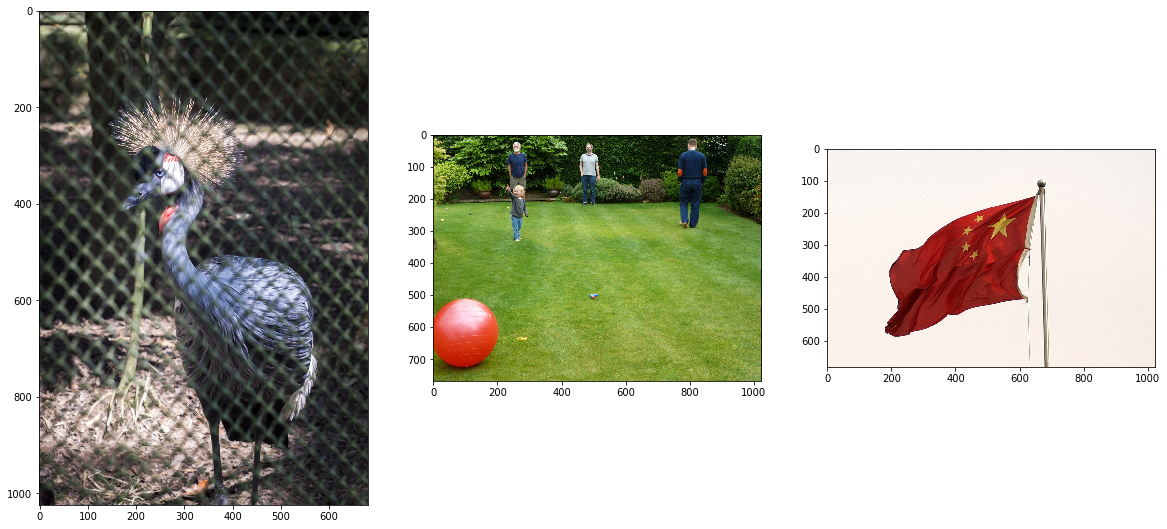

In [11]:
from PIL import Image
import matplotlib.pylab as plt
%matplotlib inline

path = data_dir / "train_overfit"

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(Image.open(path / "000062a39995e348.jpg"))

plt.subplot(132)
plt.imshow(Image.open(path / "0003d84e0165d630.jpg"))

plt.subplot(133)
plt.imshow(Image.open(path / "00068d5450f0358b.jpg"))

In [12]:
import json

gt_annotations = None
path = data_dir / "annotations"

with (path / "train_overfit.json").open("r") as h:
    data = json.load(h)
    gt_annotations = data['annotations']

### Check 10 images overfitting - Faster-RCNN X

In [19]:
from datetime import datetime
now = datetime.now()

config_name = "train_overfit_faster_rcnn_X-101-64x4d-FPN_2x"
output_path = base_output_path / "output-OpenImagesObjectDetections" / config_name / now.strftime("%Y%m%d_%H%M")
detectron_weights_path = Path(".") / "weights" / "Faster-RCNN-X-101-64x4d-FPN" / "model_final.pkl"
config = Path(".") / "configs" / "train" / "{}.yaml".format(config_name)
other_confs = "OUTPUT_DIR {} ".format(output_path)

                
!mkdir -p {output_path}
output_path = output_path.as_posix()
cmd = "{Detectron}/tools/train_net_step.py --cfg {config} ".format(Detectron=Detectron, config=config) + \
    "--set {other_confs} --load_detectron {detectron_weights_path} ".format(other_confs=other_confs, detectron_weights_path=detectron_weights_path) + \
    "--use_tfboard"

!echo python3 {cmd} > {output_path}/run.cmd
!python3 {cmd} > {output_path}/train.log

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Run inference on train_overfitting dataset

In [30]:
output_path = Path(output_path)

inference_output_path = output_path / "inference_on_train"
input_path = data_dir / "train_overfit"
weights_path = output_path / "ckpt" / "model_step999.pth"
other_confs = "--image_dir {} --output_dir {} --load_ckpt {} ".format(input_path, inference_output_path, weights_path)


!mkdir -p {inference_output_path}
output_path = output_path.as_posix()
cmd = "{Detectron}/tools/infer_simple.py --cfg {config} ".format(Detectron=Detectron, config=config) + \
    "{other_confs}".format(other_confs=other_confs)

!echo python3 {cmd} > {output_path}/run.cmd
!python3 {cmd} > {output_path}/inference.log

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/bin/sh: 1: pdfunite: not found


In [17]:
!ls {inference_output_path}

000026e7ee790996.jpg.png  0002ab0af02e4a77.jpg.png  00045d609ca3f4eb.jpg.png
000062a39995e348.jpg.png  0002cc8afaf1b611.jpg.png  00068d5450f0358b.jpg.png
0000c64e1253d68f.jpg.png  0003d84e0165d630.jpg.png
000132c20b84269b.jpg.png  000411001ff7dd4f.jpg.png


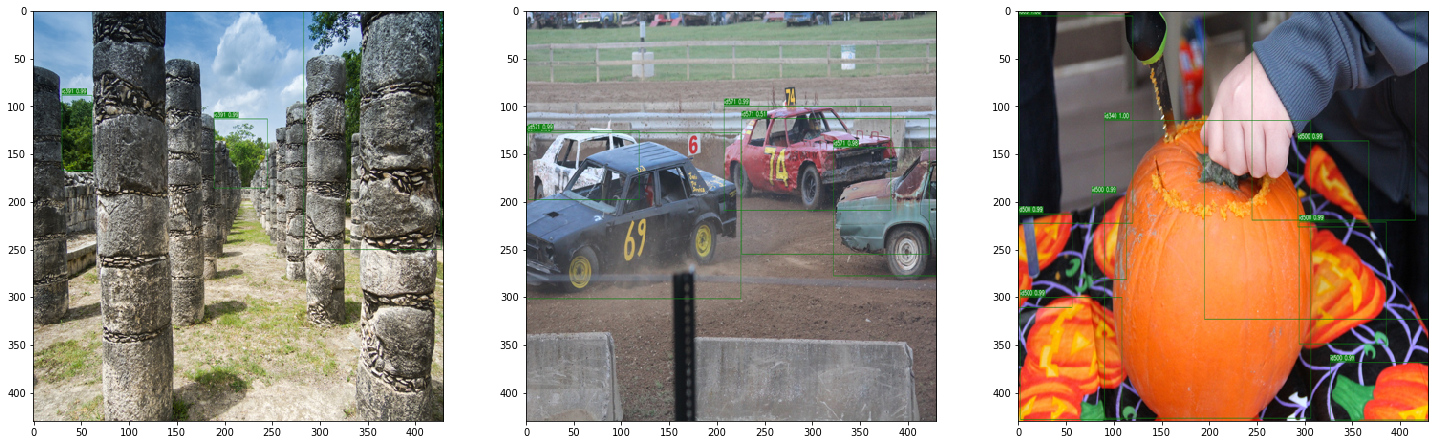

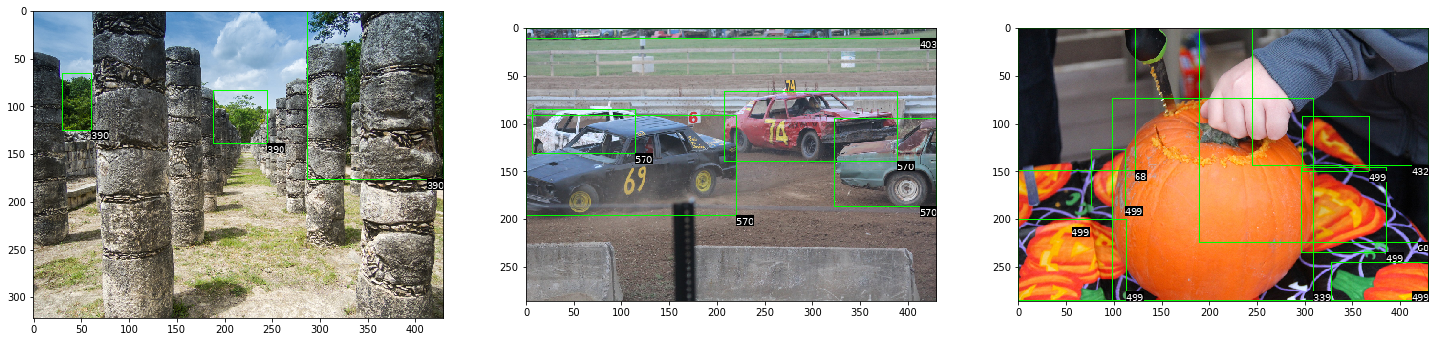

In [36]:
from PIL import Image
import matplotlib.pylab as plt
%matplotlib inline


plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.imshow(Image.open(inference_output_path / "000026e7ee790996.jpg.png").resize((430, 430), Image.BICUBIC))

plt.subplot(132)
plt.imshow(Image.open(inference_output_path / "0000c64e1253d68f.jpg.png").resize((430, 430), Image.BICUBIC))

plt.subplot(133)
plt.imshow(Image.open(inference_output_path / "00045d609ca3f4eb.jpg.png").resize((430, 430), Image.BICUBIC))


img_path = data_dir / "train_overfit"
plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.imshow(get_img_gt_target(img_path, "000026e7ee790996", gt_annotations))

plt.subplot(132)
plt.imshow(get_img_gt_target(img_path, "0000c64e1253d68f", gt_annotations))

plt.subplot(133)
plt.imshow(get_img_gt_target(img_path, "00045d609ca3f4eb", gt_annotations))


## Train models

Training dataset contains: 162894 images

In [8]:
!find ../input/as_mscoco/train/ -name *.jpg | wc -l
!find ../input/as_mscoco/val/ -name *.jpg | wc -l
!find ../input/as_mscoco/test/ -name *.jpg | wc -l

505563
41620
125436


## Run training - Finetunning of Faster-RCNN

In [ ]:
from datetime import datetime
now = datetime.now()

config_name = "train_faster_rcnn_X-101-64x4d-FPN_2x_gpu_1"
output_path = base_output_path / "output-OpenImagesObjectDetections" / config_name / now.strftime("%Y%m%d_%H%M")
detectron_weights_path = Path(".") / "weights" / "Faster-RCNN-X-101-64x4d-FPN" / "model_final.pkl"
config = Path(".") / "configs" / "train" / "{}.yaml".format(config_name)
other_confs = "OUTPUT_DIR {} ".format(output_path)


!mkdir -p {output_path}
output_path = output_path.as_posix()
cmd = "{Detectron}/tools/train_net_step.py --cfg {config} ".format(Detectron=Detectron, config=config) + \
    "--set {other_confs} --load_detectron {detectron_weights_path} ".format(other_confs=other_confs, detectron_weights_path=detectron_weights_path) + \
    "--use_tfboard"

!cp {config} {output_path}
!echo python3 {cmd} > {output_path}/run.cmd
!python3 {cmd} > {output_path}/train.log

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
from datetime import datetime
now = datetime.now()

config_name = "train_faster_rcnn_X-101-32x8d-FPN_1x_gpu_2"
output_path = base_output_path / "output-OpenImagesObjectDetections" / config_name / now.strftime("%Y%m%d_%H%M")
detectron_weights_path = Path(".") / "weights" / "X-101-32x8d-FPN_1x" / "model_final.pkl"
config = Path(".") / "configs" / "train" / "{}.yaml".format(config_name)
other_confs = "OUTPUT_DIR {} ".format(output_path)


!mkdir -p {output_path}
output_path = output_path.as_posix()
cmd = "{Detectron}/tools/train_net_step.py --cfg {config} ".format(Detectron=Detectron, config=config) + \
    "--set {other_confs} --load_detectron {detectron_weights_path} ".format(other_confs=other_confs, detectron_weights_path=detectron_weights_path) + \
    "--use_tfboard"

!cp {config} {output_path}
!echo python3 {cmd} > {output_path}/run.cmd
!python3 {cmd} > {output_path}/train.log

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [8]:
from datetime import datetime
now = datetime.now()

config_name = "train_faster_rcnn_X-101-64x4d-FPN_2x_gpu_1"
output_path = base_output_path / "output-OpenImagesObjectDetections" / config_name / now.strftime("%Y%m%d_%H%M")
detectron_weights_path = Path(".") / "weights" / "Faster-RCNN-X-101-64x4d-FPN" / "model_final.pkl"
config = Path(".") / "configs" / "train" / "{}.yaml".format(config_name)
other_confs = "OUTPUT_DIR {} ".format(output_path)


!mkdir -p {output_path}
output_path = output_path.as_posix()
cmd = "{Detectron}/tools/train_net_step.py --cfg {config} ".format(Detectron=Detectron, config=config) + \
    "--set {other_confs} --load_detectron {detectron_weights_path} ".format(other_confs=other_confs, detectron_weights_path=detectron_weights_path) + \
    "--use_tfboard"

!cp {config} {output_path}
!echo python3 {cmd} > {output_path}/run.cmd
!python3 {cmd} > {output_path}/train.log

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
^C
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f3e885aff28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/l

### Resume training - Finetunning of Faster-RCNN

In [8]:
from datetime import datetime
now = datetime.now()

config_name = "finetune_faster_rcnn_X-101-64x4d-FPN_2x_gpu_1"
output_path = base_output_path / "output-OpenImagesObjectDetections" / config_name / now.strftime("%Y%m%d_%H%M")
chkpt_weights_path = base_output_path / "output-OpenImagesObjectDetections" / "train_faster_rcnn_X-101-64x4d-FPN_2x_gpu_1" / "20180805_1313"/ "ckpt" / "model_step7999.pth"
config = Path(".") / "configs" / "train" / "{}.yaml".format(config_name)
other_confs = "OUTPUT_DIR {} ".format(output_path)


!mkdir -p {output_path}
output_path = output_path.as_posix()
cmd = "{Detectron}/tools/train_net_step.py --cfg {config} ".format(Detectron=Detectron, config=config) + \
    "--set {other_confs} --load_ckpt {chkpt_weights_path} ".format(other_confs=other_confs, chkpt_weights_path=chkpt_weights_path) + \
    "--use_tfboard --resume"

!echo python3 {cmd} > {output_path}/run.cmd
!python3 {cmd} > {output_path}/train.log

^C
Traceback (most recent call last):
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/Detectron.pytorch/tools/train_net_step.py", line 438, in <module>
    main()
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/Detectron.pytorch/tools/train_net_step.py", line 217, in main
    cfg.TRAIN.DATASETS, cfg.TRAIN.PROPOSAL_FILES)
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/Detectron.pytorch/lib/datasets/roidb.py", line 62, in combined_roidb_for_training
    roidbs = [get_roidb(*args) for args in zip(dataset_names, proposal_files)]
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/Detectron.pytorch/lib/datasets/roidb.py", line 62, in <listcomp>
    roidbs = [get_roidb(*args) for args in zip(dataset_names, proposal_files)]
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/Detectron.pytorch/lib/datasets/roidb.py", line 47, in get_roidb
    crowd_filter_thresh=cfg.TRAIN.CROWD_FILTER_THRESH
  File "/h